<a href="https://colab.research.google.com/github/good0neighbour/ESTCampAI/blob/main/TextMining/ex02_%EA%B0%90%EC%A0%95%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gensim
# gensim 설치 후 세션 다시 시작.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ESTCampAI/TextMining
# 세션 다시 시작 후에는 경로가 초기화되어 다시 실행해주어야 한다.

/content/drive/MyDrive/ESTCampAI/TextMining


### 네이버 쇼핑 리뷰 데이터 기반으로 임베딩 맛보기

In [ ]:
import pandas as pd
data = pd.read_csv('./data/naver_shopping.txt', delimiter='\t', header = None)

In [ ]:
data.head(3)

0                                                  1
0  5                                            배공빠르고 굿
1  2                      택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2  5  아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...

In [ ]:
# 컬럼명 업데이트
data.columns = ['평점','리뷰']

In [ ]:
data.head()

평점                                                 리뷰
0   5                                            배공빠르고 굿
1   2                      택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2   5  아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3   2  선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4   5                  민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ

In [ ]:
# 리뷰(document)만 인덱싱
text = data['리뷰']

### 1. 정제
- 1.1 결측치 확인
- 1.2 특수문자 제거

In [ ]:
data.info()
# 결측치 없음 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   평점      200000 non-null  int64 
 1   리뷰      200000 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


- 1.2 특수문자 제거 -> re 활용

In [ ]:
import re

# r"" : 원시(raw)문자열, \를 하나만 사용 가능하게끔 만듬!
pattern = r'[^a-zA-Z0-9가-힣\s\.\?\!]'

# 알파벳, 숫자, 한글문자, 공백을 제외한 패턴
# 리뷰가 길어지는 경우, 문장 구분을 위해 공백(\s), .?! 보존
# "\s"는 공백 문자를 의미하며, 여기에는 줄바꿈(\n)도 포함됨
# ^ : not

In [ ]:
from tqdm import tqdm

new_doc = []
for doc in tqdm(text):
  cleaned_doc = re.sub(pattern, '', doc)
  new_doc.append(cleaned_doc)

100%|██████████| 200000/200000 [00:00<00:00, 210565.15it/s]


In [ ]:
# 정제 된 텍스트 데이터 컬럼으로 추가
data['cleaned_doc'] = new_doc

In [ ]:
data.head(3)

평점                                                 리뷰  \
0   5                                            배공빠르고 굿   
1   2                      택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고   
2   5  아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...   

                                         cleaned_doc  
0                                            배공빠르고 굿  
1                      택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고  
2  아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...

```
!pip install git+https://github.com/ssut/py-hanspell.git
```

```from hanspell import spell_checker
import time
from tqdm import tqdm

right_spell = []

for doc in tqdm(new_doc):  # new_doc: 문장 리스트
    try:
        corrected = spell_checker.check(doc)
        right_spell.append(corrected.checked)
        time.sleep(0.5)  # 차단 방지
    except Exception as e:
        right_spell.append(doc)  # 오류 시 원문 저장
```

### 2. 형태소 분리
- 2.1 형태소 분리, 어간 추출, 정규화, 원하는 품사 추출, 불용어 제거, 띄어쓰기 교정

In [ ]:
!pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 15.8 MB/s eta 0:00:00
  Created wheel for kiwipiepy_model: filename=kiwipiepy_model-0.21.0-py3-none-any.whl size=35593192 sha256=b4d263f015ef3a74f9cdce2cbfe1e800eeb72a43ea95970711a38bf93700b16d
  Stored in directory: /root/.cache/pip/wheels/5f/94/81/3e8b1478625f1bdb3b72733dfe3086a8f77a8f25db2b1d746b
Successfully built kiwipiepy_model


In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 15.1 MB/s eta 0:00:00


In [ ]:
# 형태소 분석기 초기화
from konlpy.tag import Okt
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords

okt = Okt()
kiwi = Kiwi()
stopwords = Stopwords()

In [ ]:
stopwords_list = [word for word, tag in stopwords.stopwords]

In [ ]:
# 사용자 함수 정의하기
def pos_tagging(text):
  # 1. 띄어쓰기 교정
  text = kiwi.space(text)

  # 2. 품사태깅(형태소 분리)
  pos_words = okt.pos(
      text,
      stem = True, # 어간추출
      norm = True # 덩규화(표준화)
  )

  # 3. 원하는 품사 추출(명사, 형용사, 동사)
  tagged_list = []

  for word, tag in pos_words:
    if tag in ['Noun', 'Adjective', 'Verb']: # 명사, 형용사, 동사인가?
      if word not in stopwords_list: # 불용어 사전에 해당되지 않는가?
        tagged_list.append(word)

  return tagged_list

In [ ]:
# 함수 적용
#tagged_doc = []

#for text in tqdm(data['cleaned_doc']): # 모든 정제리뷰를 순회
#  tagged_doc.append(pos_tagging(text)) # 형태소 분리 및 전처리된 text를 tagged_doc에 추가

In [ ]:
import pickle
import pandas as pd
from tqdm import tqdm

# DataFrame에 list 자료형은 csv로 저장하는 경우에 데이터타입이 문자열로 변경되어버리기 때문에 pkl등 다른 확장자를 이용하는 것이 좋다.
data = pd.read_pickle('data/naver_shopping(정제 및 토큰화 완료).pkl')
data.head()

평점                                                 리뷰  \
0   5                                            배공빠르고 굿   
1   2                      택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고   
2   5  아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...   
3   2  선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...   
4   5                  민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ   

                                         cleaned_doc  \
0                                            배공빠르고 굿   
1                      택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고   
2  아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...   
3  선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...   
4                    민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요    

                                          tagged_doc  
0                                       [배공, 빠르다, 굿]  
1                  [택배, 엉망, 용, 저희, 집, 밑, 층, 놔두다, 가다]  
2  [아주, 좋다, 바지, 정말, 좋다, 개, 구매, 하다, 가격, 대박, 이다, 바느...  
3  [선물, 용, 받다, 전달, 하다, 하다, 상품, 이다, 머, 컵, 오다, 당황, ...  
4            [민트, 색상, 예쁘다, 옆, 손잡이, 거, 용, 도로, 사용, 되다]

### Word2Vec
- 단어 임베딩 방법론(모델) 중 하나
> 두 가지 방법<br>
> CBOW : 주변에 있는 단어를 입력으로 중간에 있는 단어를 학습/예측하는 방법<br>
> Skip-gram : 중간에 있는 단어를 입역으로 주변 단어 학습/예측하는 방법

In [ ]:
# word2vec 모델을 활용한 임베딩 알아보기
import gensim.downloader as api
# gensim : 복잡한 설치 없이 간단한 api 호출로 사전 학습된 워드 임베딩 모델 제공

In [ ]:
# 사용가능한 여러 모델 리스트업
for model_name, model_data in sorted(api.info()['models'].items()):
    num_records = model_data.get('num_records', -1)
    description = model_data['description'][:40] + '...'

    print(f"{model_name} ({num_records} records): {description}")

__testing_word2vec-matrix-synopsis (-1 records): [THIS IS ONLY FOR TESTING] Word vecrors ...
conceptnet-numberbatch-17-06-300 (1917247 records): ConceptNet Numberbatch consists of state...
fasttext-wiki-news-subwords-300 (999999 records): 1 million word vectors trained on Wikipe...
glove-twitter-100 (1193514 records): Pre-trained vectors based on  2B tweets,...
glove-twitter-200 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-twitter-25 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-twitter-50 (1193514 records): Pre-trained vectors based on 2B tweets, ...
glove-wiki-gigaword-100 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-200 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-300 (400000 records): Pre-trained vectors based on Wikipedia 2...
glove-wiki-gigaword-50 (400000 records): Pre-trained vectors based on Wikipedia 2...
word2vec-google-news-300 (3000000 records): Pre-trai

- Records : 레코드의 수, 즉 데이터의 개수를 의미(각 "레코드"는 임베딩된 단어 하나를 의미)

| 모델 이름                           | 레코드 수      | 설명                                                                                                  |
|-------------------------------------|----------------|-------------------------------------------------------------------------------------------------------|
| conceptnet-numberbatch-17-06-300    | 1,917,247      | ConceptNet Numberbatch는 개념 간의 관계를 학습한 모델.                                                 |
|                                     |                | 상식을 이해하고 개념 간 관계를 연결시키기 위해 개발됨.                                                 |
|                                     |                | 주로 의미 네트워크 연구에 사용됨. "고양이"와 "동물" 간의 관계를 학습.                                  |
| fasttext-wiki-news-subwords-300     | 999,999        | fastText는 단어뿐만 아니라 서브워드(단어의 작은 부분)를 학습.                                          |
|                                     |                | "unbelievable"을 "un", "believe", "able"로 나누어 학습.                                                 |
|                                     |                | Wikipedia와 뉴스 기사 데이터를 기반으로 학습됨.                                                       |
| glove-twitter-100                   | 1,193,514      | GloVe는 Stanford에서 개발된 모델로, 단어 간의 공간적 관계를 벡터로 표현.                               |
|                                     |                | 트위터 데이터(2억 개 트윗)로 학습되어 소셜 미디어 자연어 처리 작업에 적합.                             |
| word2vec-google-news-300            | 3,000,000      | Word2Vec은 구글 뉴스 데이터로 학습된 모델.                                                             |
|                                     |                | 뉴스 기사의 단어 간 유사성 및 의미적 관계를 잘 포착.                                                   |
|                                     |                | 뉴스 데이터 기반이기 때문에 자연어 처리에 많이 사용됨.                                                 |
| word2vec-ruscorpora-300             | 184,973        | Word2Vec ruscorpora는 러시아어 텍스트 기반의 모델로,                                                   |
|                                     |                | 러시아어 자연어 처리 작업에 사용됨.                                                                   |

In [ ]:
# gensim에서는 여러개의 사전학습 모델이 제공됨
# 이 중에서 word2vec-google-news-300 모델 로드하기
model = api.load('word2vec-google-news-300')
# 구글 뉴스 데이터로 훈련된 Word2Vec 모델
# 3백만 개의 단어 벡터를 포함하고 있으며, 각 단어는 300차원 벡터로 표현

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# 'cat' 단어의 임베딩 벡터를 가져옴
cat_vector = model['cat']
len(cat_vector)

300

In [ ]:
# 'cat'이라는 단어에 대응하는 300차원 벡터가 출력
cat_vector.shape

(300,)

In [ ]:
# 유사도를 계산하여, 주어진 단어와 벡터 공간성에서 가장 가까운 단어를 나열
# 기본 코사인 유사도 점수 (-1 ~ 1 사이의 값, 벡터가 동일한 방향일 수록 값은 1에 가까워지고, 벡터가 반대방향일수록 -1에 가까워진다)
model.most_similar('cat')

[('cats', 0.8099379539489746),
 ('dog', 0.760945737361908),
 ('kitten', 0.7464985251426697),
 ('feline', 0.7326234579086304),
 ('beagle', 0.7150582671165466),
 ('puppy', 0.7075453400611877),
 ('pup', 0.6934291124343872),
 ('pet', 0.6891531348228455),
 ('felines', 0.6755931973457336),
 ('chihuahua', 0.6709762215614319)]

-1 이상 1이하의 값을 가지며 값이 1에 가까울수록 유사도가 높다고 판단
- 두 벡터가 가리키는 방향이 얼마나 유사한가를 의미
<img src = "https://wikidocs.net/images/page/24603/코사인유사도.PNG"/>

> **결과 해석:**  
> - 두 벡터가 완전히 동일한 방향이면(각도 $(\theta = 0$)) 유사도는 1  
> - 두 벡터가 서로 직교(각도 $(90^\circ$))하면 유사도는 0  
> - 두 벡터가 반대 방향이면(각도 $(\theta = 180^\circ$)) 유사도는 -1  
> - **문서 유사도 계산** 시 보통 음수 값은 잘 안 나오므로(벡터가 음수값을 가질 때 제외), 0에 가까울수록 유사도가 낮고 1에 가까울수록 유사도가 높다고 해석함  

### Word2Vec 직접 학습
- 단어의 본질적인 의미를 파악할 수 있도록 수치화를 정교하게 해보자.
---
- CBOW : 주변에 있는 단어를 입력으로 중간에 있는 단어를 학습/예측하는 방법
- Skip-gram : 중간에 있는 단어를 입력으로 주변 단어를 학습/예측하는 방법
#### 말뭉치의 맥락과 타겟
<img src='https://img.notionusercontent.com/s3/prod-files-secure%2F4cc1fb7e-3ef4-49f8-a0ac-8b575c63345f%2F644d4eba-d8c4-4aea-8d85-a324323d8f65%2Fimage.png/size/w=1420?exp=1758893632&sig=YqbLopA0LNfYhCJ-Ps2im5-I2HGt1RaP5RhGe9UgN8Q&id=279aa318-b143-8055-ae56-cc5640414e79&table=block' width=500px/>

#### CBOW
<img src='https://img.notionusercontent.com/s3/prod-files-secure%2F4cc1fb7e-3ef4-49f8-a0ac-8b575c63345f%2F6b8c145a-a0a5-4f14-ba64-844884c85f36%2Fimage.png/size/w=1420?exp=1758893693&sig=mqoDKU-zX6Cc28QiSWseSWnK1RZkga2zCHg9t2-R9LM&id=279aa318-b143-8055-b45d-fa05b46af0f6&table=block' width=500px height=400px/>

#### Skip-gram
<img src='https://img.notionusercontent.com/s3/prod-files-secure%2F4cc1fb7e-3ef4-49f8-a0ac-8b575c63345f%2F1a6686ee-190a-4212-ae1e-8fcd2914a9d0%2Fimage.png/size/w=1420?exp=1758893815&sig=2w0TON-_IC4XMPAhcvaHsuwS1ygjdss3batkOsTG84U&id=279aa318-b143-8091-861e-e78200b7b288&table=block' />

> 보통은 일반적으로 CBOW방식에 비해 Skip-gram 방식 + Negative Sampling 방법이 임베딩 품질이 좋다
- Skip-gram은 같은 Corpus로도 더 많은 학습 데이터를 확보할 수 있기 때문에 단어 임베딩의 품질이 좋음
> 그런데 Skip-gram의 경우 모든 문맥 단어 쌍을 학습하는데, 계산 비용이 큼
> - Negative Sampling : Skip-gram 모델에서 효율적으로 학습을 진행하기 위해서 사용하는 샘플링 기법

In [ ]:
from gensim.models import Word2Vec
# Word2Vec 클래스(학습X)

In [ ]:
# Word2Vec 모델 객체를 생성하고, 주어진 데이터셋으로 학습(data['tagged_doc'])
w2v = Word2Vec(
    window = 3, # 한 단어와 관련된 인접한 단어의 범위를 지정 (window 크기)
    min_count = 5, # 특정 단어가 학습에 포함되기 위한 최소 등장 회수(5회 미만 단어는 고려하지 x)
    sg = 1, # Skip-gram 모델 사용(sg = 1), CBOW 모델 사용(sg = 0)
    vector_size = 100, # 각 단어를 임베딩할 벡터의 차원 수(100차원의 벡터)
    negative = 5, # Negative Sampling 사용, 음성 샘플링 개수(5개의 단어를 샘플링)
    # Negative Sample : 목표 단어가 아닌 무작위 단어(음성 샘플)을 선택해서 추가 학습
    # 일반적으로 5, 10 설정
    # 전체 단어로 진행해야하지만, 그럴 경우 연산량이 너무 많아서 속도 문제가 발생함
    sentences = data['tagged_doc'] # 학습에 사용할 문장 데이터가 담긴 데이터셋
)

In [ ]:
# '배송'이라는 단어에 대한 임베딩 벡터 확인
w2v.wv.get_vector('배송').shape
# wv : word vector

(100,)

In [ ]:
# '만족'과 유사한 단어를 20개 확인(코사인 유사도 기준으로 상위 20개)
w2v.wv.most_similar('만족', topn = 20)

[('만족하다', 0.8073432445526123),
 ('최상', 0.7137962579727173),
 ('만족스럽다', 0.713725209236145),
 ('대대', 0.6917969584465027),
 ('대만', 0.6805012822151184),
 ('민족', 0.6751699447631836),
 ('훌륭하다', 0.6713840365409851),
 ('맘에듬', 0.6670438647270203),
 ('젛', 0.6647169589996338),
 ('최강', 0.6634274125099182),
 ('핮', 0.656528115272522),
 ('젛아', 0.6550523042678833),
 ('합닏', 0.6497409343719482),
 ('갠차다', 0.6458066701889038),
 ('괜찬네', 0.645673394203186),
 ('만점', 0.6413519978523254),
 ('흐뭇하다', 0.6368861198425293),
 ('빨랏구', 0.6366013288497925),
 ('령', 0.6345325708389282),
 ('닏', 0.633311927318573)]

### 평점을 기반으로 긍/부정 분류기 + 가중치 분석
1. 평정을 기반으로 라벨 생성(4, 5인 경우 긍정 1, 그 외 부정 0)
2. 각 리뷰에 대한 평균 벡터 계산
3. 로지스틱 회귀 모델링
4. 가중치 시각화

In [ ]:
data['평점'].value_counts()

평점
5    81177
2    63989
1    36048
4    18786
Name: count, dtype: int64

In [ ]:
# 1. 평점 기반으로 라벨 생성(4와 5인 경우 긍정 1, 그 외 부정 0)
label = []
for rating in data['평점']:
  if rating > 3:
    label.append(1) # 긍정(1)
  else:
    label.append(0) # 부정(0)

In [ ]:
data['label'] = label
data.head(1)

평점       리뷰 cleaned_doc    tagged_doc  label
0   5  배공빠르고 굿     배공빠르고 굿  [배공, 빠르다, 굿]      1

In [ ]:
import numpy as np
# 2.각 리뷰에 대한 평균 벡터 계산
# 벡터의 차원 추출
vector_size = w2v.vector_size
# 각 리뷰의 평균 벡터값을 담아줄 리스트
X_w2v_list = []
# 평균 벡터 계산하기
for doc in data['tagged_doc']:
  vecs = [] # 해당 리뷰의 각 벡터값을 담아둘 리스트

  for token in doc: # 닫 문장의 토믄에 대해 순회
    if token in w2v.wv : # Word2Vec에 해당 토큰이 들어있니?
      vecs.append(w2v.wv[token]) # 벡터 추가

  if len(vecs) > 0 : # 벡터의 길이가 0보다 큰가? -> 정제하는 과정에서 없어질 수도 있음
  # 문장을 형태소 단위로 나누었을 때 결과로 나온 토큰이 모두 Word2Vec 모델의 단어 사전에 없는 단어(out-of-vocabulary)
  # 일 경우 그 문장은 Word2Vec 벡터로 표현할 수 없으므로 vecs 리스트가 비어있게 됨
    avg_vec = np.mean(vecs, axis = 0) # 각 차원별로 평균 계산
  else : # 벡터의 길이가 없는 경우 -> 정제하는 과정에서 삭제된 경우
   avg_vec = np.zeros(vector_size)

  X_w2v_list.append(avg_vec)

In [ ]:
# 3. 로지스틱 회귀(분류) 모델링
# 리스트를 2차원으로 array 형변환
X_w2v = np.vstack(X_w2v_list)

In [ ]:
X_w2v.shape
# 행 : 데이터의 개수
# 열 : 벡터 차원

(200000, 100)

In [ ]:
# 교차검증 확인
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
# StratifiedKFold : 교차 겁증 시 각 데이터셋의 라벨 비율을 동일하게 유지

In [ ]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2025)
logi = LogisticRegression(max_iter = 10000, random_state = 2025)

scores = cross_val_score(logi, X_w2v, data['label'], cv = cv)

In [ ]:
print(scores)
print(scores.mean())

[0.874375 0.87475  0.872175 0.873175 0.874675]
0.8738300000000001


In [ ]:
# 4. 가중치 시각화
# 전체 데이터로 Logistic Regression 모델을 학습하여, 각 Word2Vec 차원에 대한 가중치(계수)를 얻음
logi.fit(X_w2v, data['label'])

LogisticRegression(max_iter=10000, random_state=2025)

In [ ]:
coef_vector = logi.coef_[0] # 로지스틱 회귀 모델의 계수
coef_vector.shape # vector_size

(100,)

### 감정 기여도 계산하기
- 각 단어가 감성 분류에 얼마나 기여하는지, 수치로 표현해보자
> 벡터간 내적 계산 활용
> - 단어 임베딩 벡터
> - 로지스틱 회귀모델 계수 벡터

In [ ]:
# 데이터 내에 등장하는 단어 집합 생성(w2v에 존재하는 단어만 고려)
word_set = set()
for tokens in data['tagged_doc']:
  for token in tokens:
    if token in w2v.wv:
      word_set.add(token)

In [ ]:
# 단어 집합 사용해, 각 단어의 임베딩 벡터와 모델 가중치의 내적을 계산하여 감성 기여도 평가를 할 수 있음
word_set
# word_set에는 모델에서 임베딩된 단어만 포함됨

{'고릴라',
 '놀',
 '뭉치다',
 '오븐',
 '서도',
 '풍부하다',
 '겹',
 '양파',
 '고기랑',
 '스테이크',
 '무더위',
 '탁구공',
 '입',
 '살다',
 '찾아가다',
 '꽂다',
 '파이다',
 '헤진',
 '일해',
 '음정',
 '길냥이',
 '와이프',
 '허위',
 '시리얼',
 '일도',
 '축소',
 '마노',
 '도포',
 '관리',
 '결제',
 '일만',
 '실버',
 '마당',
 '감기',
 '농사',
 '남친',
 '습제',
 '걸어가다',
 '욕심',
 '유식',
 '킨더밀쉬',
 '찬',
 '타라',
 '오',
 '미세하다',
 '울렁',
 '사드',
 '대쉬보드',
 '리필',
 '과대',
 '농부',
 '시켯',
 '죽다',
 '균',
 '부르다',
 '맥스',
 '벌어지다',
 '펀치',
 '핬',
 '변형',
 '식히다',
 '문자',
 '재미없다',
 '지저분하다',
 '가구',
 '핫도그',
 '의문',
 '가라앉다',
 '익스',
 '구미',
 '피곤하다',
 '헤졌어',
 '새우',
 '잡',
 '워머',
 '독촉',
 '브레드',
 '다가오다',
 '꽁꽁',
 '자유',
 '레이어',
 '슈크림',
 '쫄면',
 '반듯하다',
 '외출',
 '쿨링감',
 '일석이조',
 '서버',
 '칙칙하다',
 '싼마이',
 '유투',
 '핀셋',
 '나중',
 '어후',
 '금색',
 '놀래다',
 '팔뚝',
 '금박',
 '삐끗',
 '생으로',
 '악취',
 '접기',
 '켯',
 '깨지다',
 '이군',
 '유리컵',
 '로션',
 '마을',
 '푸켓',
 '성용',
 '두드리다',
 '어요',
 '브래지어',
 '유아',
 '비말',
 '뜯기다',
 '불쾌하다',
 '드로즈',
 '금요일',
 '송곳',
 '프루프',
 '마치다',
 '노즐',
 '스크레치',
 '건뎅',
 '상큼',
 '풀',
 '차지',
 '말씀',
 '변비',
 '올려놓다',
 '벗어나다',
 '머리',
 '손자',


> ### Dot Product(scalar product 또는 inner product)
> - 내적 : 두 벡터를 곱하는 연산
> - 두 벡터의 같은 인덱스에 위치한 원고를 곱한 후, 그 결과를 모두 더한 값
> - 예 : 벡터 A : [a1, a2, a3], 벡터 B : [b1, b2, b3]
> - 내적 : a1 * b1 + a2 * b2 + a3 * b3
- 내적 값을 통해 양수면 해당 단어가 긍정 감성에, 음수면 부정 감성에 기여하는 것으로 해석할 수 있음

In [ ]:
# 긍정적인 단어와 부정적인 단어 기반으로 테스트
# 실제 데이터에 포함된 단어 사용해야 함
sample_words = ['깔끔하다', '실망']

for word in sample_words:
  # 1. 단어의 임베딩 벡터 추출
  embedding_vector = w2v.wv[word]

  # 2. 모델 계수 벡터와의 내적을 np.dot()을 이용하여 계산
  dot_product = np.dot(embedding_vector, coef_vector)

  # 3. 결과 출력
  print(f'단어 : {word}')
  print(f'내적 결과 : {dot_product}')
  print('-' * 80)

단어 : 깔끔하다
내적 결과 : 10.189139473561104
--------------------------------------------------------------------------------
단어 : 실망
내적 결과 : -12.841138268809637
--------------------------------------------------------------------------------


In [ ]:
# 각 단어의 점수를, 해당 단어의 임베딩 벡터와 모델 계수의 내적
word_scores = {}
for word in word_set:
  word_scores[word] = np.dot(w2v.wv[word], coef_vector)
word_scores

{'고릴라': 0.0335441451987637,
 '놀': 2.1433567502094024,
 '뭉치다': -2.8717485066735824,
 '오븐': 4.9747579757225875,
 '서도': 0.6887974344334713,
 '풍부하다': 3.914191655863075,
 '겹': -6.9927448917329516,
 '양파': -2.9228708318596657,
 '고기랑': 1.8622629479504933,
 '스테이크': 1.3237649628354458,
 '무더위': 0.11669943349840699,
 '탁구공': -3.6342875096223977,
 '입': -2.5904575949327584,
 '살다': 3.707424332275144,
 '찾아가다': -2.022228692509016,
 '꽂다': 1.3162383731028506,
 '파이다': -5.503616510463712,
 '헤진': -1.7637159578806147,
 '일해': 1.6335452278102292,
 '음정': -0.7141202610181033,
 '길냥이': 9.054346507830873,
 '와이프': 2.334391753975114,
 '허위': -8.274734800752004,
 '시리얼': 0.05980908143451244,
 '일도': -3.1750710935527873,
 '축소': -0.324951619513553,
 '마노': -0.5463756676178629,
 '도포': -1.1843551371014458,
 '관리': 0.5297364968214223,
 '결제': -0.7767249489100863,
 '일만': -0.4338888801008521,
 '실버': 2.208710638608239,
 '마당': 0.7179377785316235,
 '감기': 3.82576770381551,
 '농사': -0.6861128732357411,
 '남친': 1.3191326769346396,
 '습제': -

In [ ]:
# sorted() # 정렬함수

# 리스트.sort() : 본체의 리스트를 정렬해서 반환
# sorted(리스트) : 본체의 리스트는 내버려두고, 새로운 리스트를 반환
sorted(word_scores.items())

[('가가', -1.149665926453898),
 ('가게', 0.5449258596763761),
 ('가격', -2.0251407022839993),
 ('가계', 0.07521409571068928),
 ('가공', -4.460901410243845),
 ('가관', -4.198611455836451),
 ('가구', -0.36082757203990556),
 ('가구라', -0.4096706305058449),
 ('가기', 0.4398350281252742),
 ('가까이', 0.9463415435289266),
 ('가깝다', -3.937373398304988),
 ('가끔', 2.079943496716056),
 ('가나', -1.0382218312262985),
 ('가나다', 0.5824986906962608),
 ('가나다라', -0.9532124630364435),
 ('가누다', -1.1588318859918032),
 ('가늘다', -4.92307559666806),
 ('가늠', -1.997770059455774),
 ('가능', -0.0017951901401827008),
 ('가능성', -3.4575458166289974),
 ('가능하다', 3.3255930755919003),
 ('가다', -0.021367288923200667),
 ('가닥', -7.473061440030358),
 ('가도', 1.2052872568106845),
 ('가동', -2.2012912648692784),
 ('가두다', 0.37717979862036183),
 ('가드', 1.5325798887506168),
 ('가득', -2.503150588603632),
 ('가득하다', -4.275053368612193),
 ('가디건', -0.21920287219167045),
 ('가뜩이나', -1.874049839789317),
 ('가라', -1.6501409108757021),
 ('가라아게', -1.8617968946624517),
 ('가

- 점수 기준으로 정렬해서 보고싶다면?

### lambda식
- 익명함수 : 이름 없이 간단한 함수 기능을 수행하는 일회용 함수
- 주로 한 줄로 표현되어 간단한 함수나 연산이 필요할 때 빠르게 정의 후 사용 가능
- 람다함수도 객체기 때문에 정의와 동시에 변수에 담을 수는 있음

<img src = "https://wikidocs.net/images/page/22804/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA_2018-11-07_05.56.24.png"/>

In [ ]:
# 단어를 점수 기준으로 오름차순 정렬
sorted_words = sorted(word_scores.items(), key = lambda x: x[1]) # 정렬 기준
# 각 튜플의 두 번째 요소(점수)를 추출해, 이 값을 기반으로 오름차순 정렬하겠다.
sorted_words

[('별루', -15.33350834468047),
 ('아깝다', -15.022086219379267),
 ('짜증', -14.846445151708547),
 ('별로', -14.492631514201896),
 ('반품', -14.485473072248052),
 ('귀찮다', -14.446385582844728),
 ('비추다', -14.40220092413158),
 ('개판', -13.811454758637444),
 ('최악', -13.668366125189474),
 ('루', -13.64270747079622),
 ('돈', -13.32499128944386),
 ('환불', -13.294709690392565),
 ('엉망', -13.121048168031809),
 ('꽝', -12.950779191475199),
 ('실망', -12.841138268809637),
 ('불편', -12.72840969130051),
 ('황당하다', -12.694016345158694),
 ('비지', -12.477435816115495),
 ('불량', -12.36426984673536),
 ('화나다', -12.148103703139052),
 ('도대체', -12.101475665385978),
 ('불가', -12.033299678314803),
 ('불만족', -11.9986984771738),
 ('조잡하다', -11.992882383550594),
 ('의심스럽다', -11.949128431747189),
 ('화가', -11.90933188692402),
 ('팔지', -11.75079092164287),
 ('양심', -11.717755574329777),
 ('건지다', -11.543133264703759),
 ('불쾌하다', -11.478544268043976),
 ('허다', -11.476994113221672),
 ('휘', -11.466881655584961),
 ('어이', -11.432580951988434),
 ('차이', 

In [ ]:
# 부정 단어(하위 15개), 긍정 단어(상위 15개) 추출
neg_words = sorted_words[:15] # 점수가 낮은 단어
pos_words = sorted_words[-15:] # 점수가 높은 단어

In [ ]:
# 두 그룹 합치기
plot_words = neg_words + pos_words

In [ ]:
# 단어와 점수를 각각 튜플로 분리
words, scores = zip(*plot_words)

In [ ]:
# 나눔 폰트(fonts-nanum)를 시스템에 설치
# '-y' 옵션은 설치 시 사용자에게 확인을 요구하지 않고 자동으로 진행되도록 함
!apt-get install -y fonts-nanum*

# 설치된 폰트를 시스템 폰트 캐시에 등록함
# 'fc-cache -fv' 명령은 폰트 캐시를 강제로 새로고침
!sudo fc-cache -fv

# Matplotlib의 캐시를 삭제
# '~/.cache/matplotlib' 폴더에 저장된 캐시 파일들을 모두 제거
# 이 과정은 새로운 폰트가 적용되지 않는 문제를 해결하는 데 유용
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
The following NEW packages will be installed:
  fonts-nanum fonts-nanum-coding fonts-nanum-eco fonts-nanum-extra
0 upgraded, 4 newly installed, 0 to remove and 35 not upgraded.
Need to get 46.0 MB of archives.
After this operation, 177 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-coding all 2.5-3 [4,988 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-eco all 1.000-7 [14.7 MB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum-extra all 20200506-1 [21.0

In [ ]:
import json

with open('data/words.json', 'w', encoding='utf-8') as f:
    json.dump(word_scores, f, ensure_ascii=False)

# ensure_ascii=False : JSON 안에 한글이 그대로 저장됨

In [ ]:
%cd /content/drive/MyDrive/ESTCampAI/TextMining
# 본인경로에 맞게끔 수정

/content/drive/MyDrive/ESTCampAI/TextMining


In [ ]:
import json

# JSON 불러오기
with open('data/words.json', 'r', encoding='utf-8') as f:
    word_scores = json.load(f)

print(word_scores)

{'고릴라': 0.0335441451987637, '놀': 2.1433567502094024, '뭉치다': -2.8717485066735824, '오븐': 4.9747579757225875, '서도': 0.6887974344334713, '풍부하다': 3.914191655863075, '겹': -6.9927448917329516, '양파': -2.9228708318596657, '고기랑': 1.8622629479504933, '스테이크': 1.3237649628354458, '무더위': 0.11669943349840699, '탁구공': -3.6342875096223977, '입': -2.5904575949327584, '살다': 3.707424332275144, '찾아가다': -2.022228692509016, '꽂다': 1.3162383731028506, '파이다': -5.503616510463712, '헤진': -1.7637159578806147, '일해': 1.6335452278102292, '음정': -0.7141202610181033, '길냥이': 9.054346507830873, '와이프': 2.334391753975114, '허위': -8.274734800752004, '시리얼': 0.05980908143451244, '일도': -3.1750710935527873, '축소': -0.324951619513553, '마노': -0.5463756676178629, '도포': -1.1843551371014458, '관리': 0.5297364968214223, '결제': -0.7767249489100863, '일만': -0.4338888801008521, '실버': 2.208710638608239, '마당': 0.7179377785316235, '감기': 3.82576770381551, '농사': -0.6861128732357411, '남친': 1.3191326769346396, '습제': -0.7361859974619629, '걸어가다': -1.69829

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family = 'NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

/tmp/ipython-input-2086756182.py:21: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2086756182.py:21: UserWarning: Glyph 47336 (\N{HANGUL SYLLABLE RU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2086756182.py:21: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2086756182.py:21: UserWarning: Glyph 44637 (\N{HANGUL SYLLABLE GGAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2086756182.py:21: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2086756182.py:21: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2086756182.py:21: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(

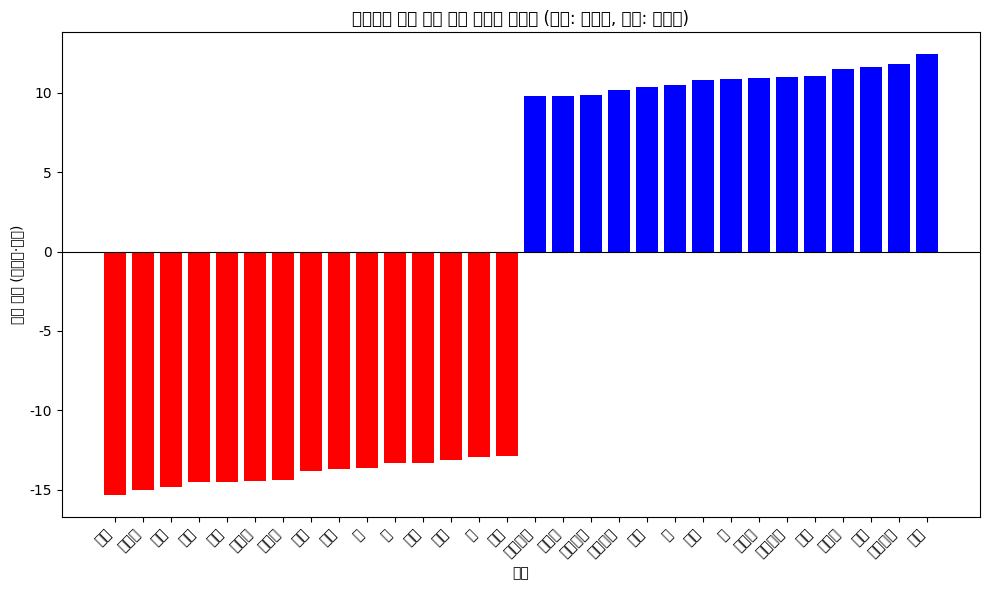

In [ ]:
# 막대그래프 시각화

plt.figure(figsize=(10, 6))

# 막대의 색상: 음수는 빨간색, 양수는 파란색으로 설정
bar_colors = ['red' if s < 0 else 'blue' for s in scores]
plt.bar(range(len(words)), scores, color=bar_colors)

# y = 0 선 추가
plt.axhline(0, color = 'black', linewidth = 0.8)

# x축 눈금에 단어 표시, 회전하여 가독성 향상
plt.xticks(range(len(words)), words, rotation = 45, ha = "right")

# x축 레이블, y축 레이블
plt.xlabel("단어")
plt.ylabel("단어 점수 (임베딩·계수)")
plt.title("로지스틱 회귀 모델 기반 단어별 가중치 (부정: 빨간색, 긍정: 파란색)")

# 레이아웃 조정으로 요소들이 겹치지 않도록 함
plt.tight_layout()
plt.show()

### 결론 및 활용방안
- 시각화를 통해 감성분석에 어떤 단어들이 긍정/부정 판단에 핵심적으로 작용하는지 알 수 있음
- 마케팅, 고객 만족도 조사, 상품 리뷰 모니터링에 인사이트를 제공받을 수 있음

---

### 주의사항 및 추가 설명

> 1. 맥락 의존성
>    - 단어 자체가 무조건 긍정 혹은 부정이라 단정 짓기 어려움  
>    - 예: “배송이 빠르다” vs “배송이 늦다”처럼 맥락에 따라 긍·부정이 달라짐  

> 2. 단순 평균 벡터의 한계
>    - 리뷰 전체 맥락을 100% 반영하기 어려움  
>    - TF-IDF 가중 평균, Doc2Vec, Sentence-BERT 등 대안적 문서 임베딩 기법 고려  

> 3. 로지스틱 회귀 모델
>    - 선형(Linear) 모델로서 비선형적 특성을 반영하기 어려움  
>    - Random Forest, XGBoost, 딥러닝 기반 모델 등 다른 접근과의 성능 비교 권장  

> 4. 표본 편향 및 토큰 수 제한
>    - min_count, window 등 Word2Vec 파라미터 설정에 따라 결과가 달라질 수 있음  
>    - 리뷰 데이터 편향(특정 제품, 특정 표현만 다수)이 존재할 수 있음  

> 5. 해석 시 참고
>    - 내적 값이 매우 높거나 낮은 단어일수록 모델의 분류 결과에 강하게 작용  
>    - 실제 리뷰에서 해당 단어들이 많이 등장했는지, 특정 제품군에 치우친 것은 아닌지 점검 필요  

---

> **추가 개선**  
> - 특정 상품에 대한 만족과 불만족에 대한 인사이트 도출은 >okt에서 명사추출로 가능
> - 다른 임베딩 기법 BERT, fastText 등과의 비교 실험
> - 사용자 정의 사전(신조어, 전문용어)에 대한 보완  